In [128]:
import pandas as pd
from preprocess import *
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import shapiro, levene, ttest_ind, chi2_contingency, f_oneway

#### 주문 데이터 처리

In [45]:
ord_df = pd.read_csv("files/olist_orders_dataset.csv")

In [46]:
date_column_list = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
ord_df = to_date(ord_df, date_column_list)

In [47]:
ord_df['estimated_dt'] = ord_df.apply(
    lambda row: date_diff(
        row['order_purchase_timestamp'],
        row['order_estimated_delivery_date']
    ),
    axis=1  # 행 단위 적용 (필수)
)

ord_df['real_dt'] = ord_df.apply(
    lambda row: date_diff(
        row['order_purchase_timestamp'],
        row['order_delivered_customer_date']
    ),
    axis=1
)

In [48]:
ord_df = handle_outliers_iqr(ord_df)

In [50]:
ord_df.dropna(inplace=True)

<Axes: >

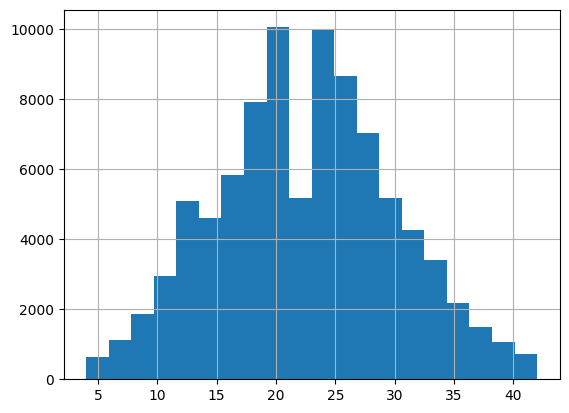

In [54]:
ord_df['estimated_dt'].hist(bins=20)

<Axes: >

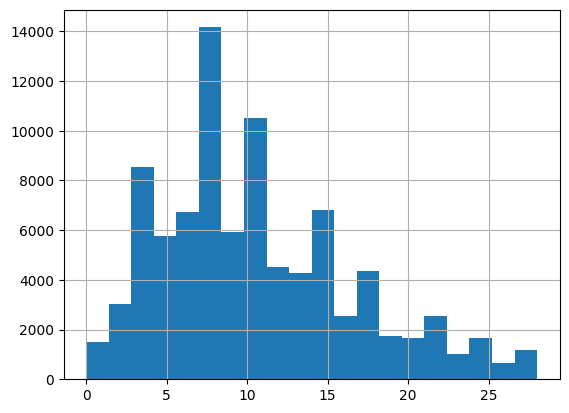

In [55]:
ord_df['real_dt'].hist(bins=20)

In [56]:
ord_df['dd'] = ord_df['estimated_dt'] - ord_df['real_dt']

<Axes: >

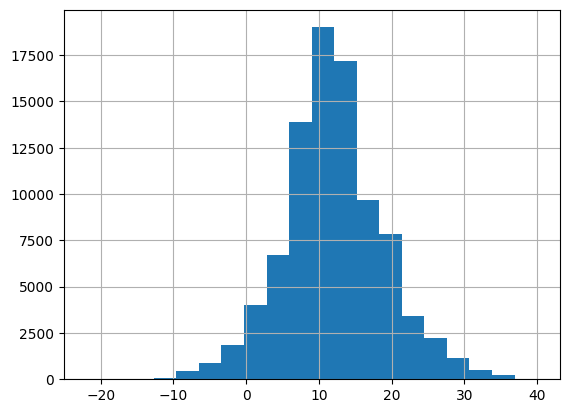

In [59]:
ord_df['dd'].hist(bins=20)

#### 리뷰 데이터 처리

In [72]:
rev_df = pd.read_csv("files/olist_order_reviews_dataset.csv")

In [75]:
rev_df['new_score'] = rev_df['review_score'].map({1:0, 2:0, 3:0, 4:1, 5:1})

In [77]:
rev_df_c = rev_df[['order_id', 'new_score']]
rev_df_c = rev_df_c.drop_duplicates()

In [78]:
rev_df_c

,order_id,new_score
0,73fc7af87114b39712e6da79b0a377eb,1
1,a548910a1c6147796b98fdf73dbeba33,1
2,f9e4b658b201a9f2ecdecbb34bed034b,1
3,658677c97b385a9be170737859d3511b,1
4,8e6bfb81e283fa7e4f11123a3fb894f1,1
...,...,...
99219,2a8c23fee101d4d5662fa670396eb8da,1
99220,22ec9f0669f784db00fa86d035cf8602,1
99221,55d4004744368f5571d1f590031933e4,1
99222,7725825d039fc1f0ceb7635e3f7d9206,1


#### 데이터 결합

In [134]:
df = pd.merge(rev_df_c, ord_df, how='inner', on='order_id')

In [135]:
df_t = df[['new_score', 'dd']]

10.397934087555337


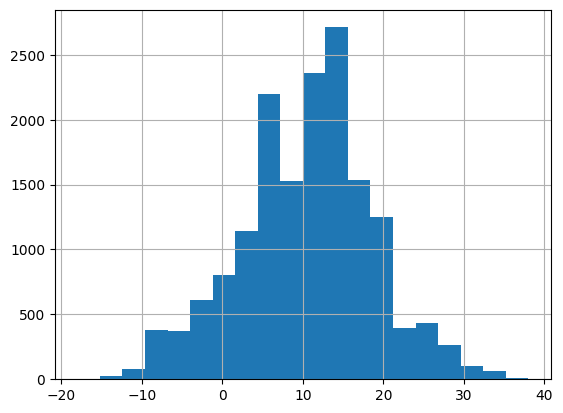

In [136]:
print(f"{df_t[df_t['new_score'] == 0]['dd'].mean()}")
df_t[df_t['new_score'] == 0]['dd'].hist(bins=20)
plt.show()

12.384828862164662


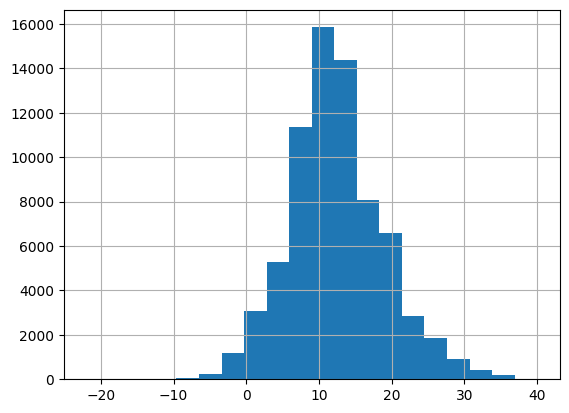

In [137]:
print(f"{df_t[df_t['new_score'] == 1]['dd'].mean()}")
df_t[df_t['new_score'] == 1]['dd'].hist(bins=20)
plt.show()

#### T-Test

In [139]:
s_1 = df_t[df_t['new_score'] == 1]['dd']
s_0 = df_t[df_t['new_score'] == 0]['dd']

In [148]:
stat_0, p_0 = stats.shapiro(s_0)
stat_1, p_1 = stats.shapiro(s_1)
print(f"""
정규성 검정 결과
======================
부정적 리뷰의 예측과 실제 배송차이 정규성
검정통계량 : {stat_0:3f}
p-value: {p_0:3f}
======================
긍정적 리뷰의 예측과 실제 배송차이 정규성
검정통계량 : {stat_1:3f}
p-value: {p_1:3f}
======================

정규성을 만족하지 않는다.
""")


정규성 검정 결과
부정적 리뷰의 예측과 실제 배송차이 정규성
검정통계량 : 0.994032
p-value: 0.000000
긍정적 리뷰의 예측과 실제 배송차이 정규성
검정통계량 : 0.991724
p-value: 0.000000

정규성을 만족하지 않는다.



In [149]:
stat, p = stats.levene(s_0, s_1)
print(f"""
등분산 검정 결과
======================
검정통계량 : {stat:3f}
p-value: {p:3f}
======================

등분선성을 만족하지 않는다.
""")


등분산 검정 결과
검정통계량 : 997.911599
p-value: 0.000000

등분선성을 만족하지 않는다.



In [152]:
tstat, pval = stats.ttest_ind(s_0, s_1, equal_var=False)

print(f"{tstat:.3f}, p-value: {pval:.3f}")

-28.626, p-value: 0.000


In [153]:
stat, pval = stats.mannwhitneyu(s_0, s_1, alternative='two-sided')
print(f"{stat:.3f}, p-value: {pval:.3f}")

512978637.000, p-value: 0.000
